# Setup

In [1]:
# For python 2 and python 3 compatibility
from __future__ import division, print_function, unicode_literals

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import os
import sys

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline

In [3]:
# Generate a pesudo-random number to produce a stable output across all runs
rng = np.random.seed(50)

In [4]:
# Configure plot figures
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [5]:
# Helper function to save figures
save_dir = "figures/"
# create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# path to save the image file
def save_fig(fig_id, tight_layout='True'):
    path = os.path.join(save_dir, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format="png", dpi=300)

# Load and Prepare the Data

In [6]:
# Dataset location
datapath = "datasets/lifestat/"

In [7]:
# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv", thousands=',', 
                             delimiter='\t', encoding='latin1', na_values='n/a')

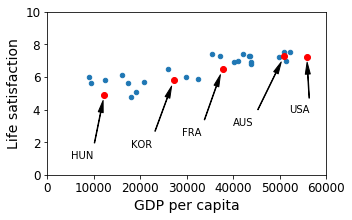

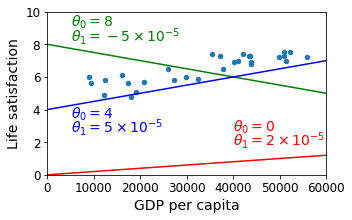

4.85305280027 4.91154458916e-05


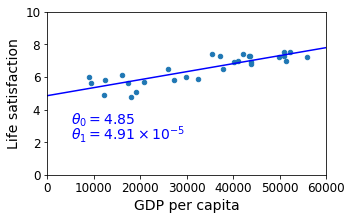

22587.49
5.96244744319


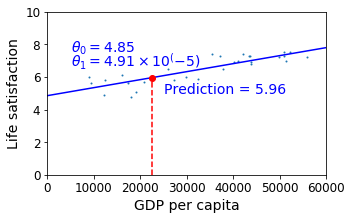

In [8]:
# Load the backup data from the 'life_satisfaction_prediction_model_1'
sys.path.insert(0, 'scripts')
from life_satisfaction_prediction_model_1 import prepare_country_stats

In [9]:
# Prepare the data
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)

In [10]:
country_stats.head()

,GDP per capita,Life satisfaction
Country,,
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Slovak Republic,15991.736,6.1


In [11]:
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

# Visualize the Data

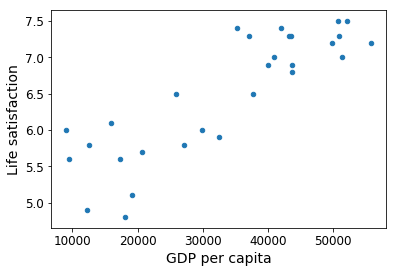

In [12]:
country_stats.plot(kind='scatter', x="GDP per capita", y="Life satisfaction")
plt.show()

In [13]:
# Select scikit's linear regression model
lin_reg_model = sklearn.linear_model.LinearRegression()

In [14]:
# Train the linear model
lin_reg_model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
# Find the prediction for Cyprus

# From model_1, Cyprus's GDP per capital = 22587.49
X_new = [[22587]]

# Display the linear model's prediction
print(lin_reg_model.predict(X_new))

[[ 5.96242338]]


## Plot Representative Training Data

In [16]:
# Display thee missing data
from life_satisfaction_prediction_model_1 import missing_data

missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


In [17]:
# Create a dict for missing data
position_text = {"Brazil": (1000, 9.0), 
                 "Mexico": (11000, 9.0), 
                 "Chile": (25000, 9.0), 
                 "Czech Republic": (35000, 9.0), 
                 "Norway": (60000, 3.0), 
                 "Switzerland": (72000, 3.0), 
                 "Luxembourg": (90000, 3.0), 
                }

In [18]:
# Import sample data from model 1 - Representative training sample
from life_satisfaction_prediction_model_1 import sample_data
from life_satisfaction_prediction_model_1 import get_intercept
from life_satisfaction_prediction_model_1 import get_slope
from life_satisfaction_prediction_model_1 import full_country_stats

Saving figure representative_training_data_scatterplot


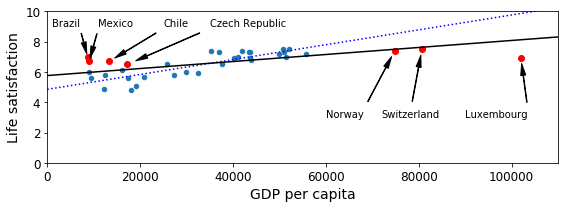

In [19]:
# Plot the missing data
sample_data.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', figsize=(8, 3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text, 
                 arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")
    
X = np.linspace(0, 11*10**4, 10**3)
plt.plot(X, get_intercept() + get_slope()*X, "b:")

lin_reg_model_full = linear_model.LinearRegression()
X_full = np.c_[full_country_stats["GDP per capita"]]
y_full = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_model_full.fit(X_full, y_full)

intercept_full, coef_full = lin_reg_model_full.intercept_[0], lin_reg_model_full.coef_[0][0]
X = np.linspace(0, 11*10**4, 10**3)
plt.plot(X, intercept_full + coef_full * X, "k")

save_fig('representative_training_data_scatterplot')

plt.show()

## Plot Overfitting Model

/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:116: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


Saving figure overfitting_model_plot


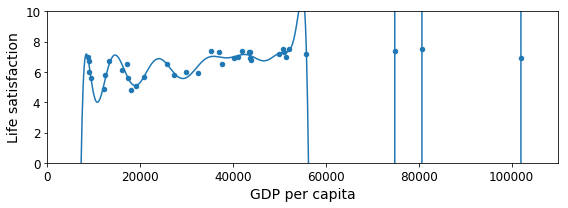

In [20]:
full_country_stats.plot(kind='scatter', x='GDP per capita', y='Life satisfaction', figsize=(8, 3))
plt.axis([0, 11*10**4, 0, 10])

# Generate polynomial and interaction features with a specified degree with no bias
poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)

# Standardize features by removing the mean and scaling to unit variance
scaler = preprocessing.StandardScaler()

# Create a linear regression model
lin_reg_model_2 = linear_model.LinearRegression()

# Apply a list of transforms and a final (composite) estimator (sequentially) using pipeline
pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg_model_2)])

# Fit the model using fit()
# It fits all the transforms one after the other and transforms the data,
# and finally fit the transformed data using the final estimator
pipeline_reg.fit(X_full, y_full)

# Apply transforms to the data, and predict with the final estimator
curve = pipeline_reg.predict(X[:, np.newaxis])

# plot the overfitting model
plt.plot(X, curve)

# save the overfitting model figure
save_fig('overfitting_model_plot')

# display the plot
plt.show()